In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/Projects/Bird_Vs_drone"

BASE_DIR = f"{PROJECT_ROOT}"
BEST_MODEL_DIR = f"{PROJECT_ROOT}/best_models"
os.makedirs(BEST_MODEL_DIR, exist_ok=True)

TRAIN_DIR = f"{BASE_DIR}/train"
VAL_DIR   = f"{BASE_DIR}/valid"
TEST_DIR  = f"{BASE_DIR}/test"

TRAIN_DIR, VAL_DIR, TEST_DIR, BEST_MODEL_DIR


('/content/drive/MyDrive/Projects/Bird_Vs_drone/train',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/valid',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/test',
 '/content/drive/MyDrive/Projects/Bird_Vs_drone/best_models')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

# Only rescale for validation & test
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

val_gen = test_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


In [ ]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="bird_vs_drone_custom_cnn")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ]
    )
    return model

model = build_custom_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


Model: "bird_vs_drone_custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,457 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
checkpoint_path = os.path.join(BEST_MODEL_DIR, "best_custom_cnn.h5")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )
]


In [ ]:
EPOCHS = 30

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6615 - loss: 1.3790 - precision: 0.6394 - recall: 0.6221
Epoch 1: val_loss improved from inf to 1.55875, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 721s 8s/step - accuracy: 0.6620 - loss: 1.3740 - precision: 0.6401 - recall: 0.6225 - val_accuracy: 0.4910 - val_loss: 1.5588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.7370 - loss: 0.5606 - precision: 0.7434 - recall: 0.6512
Epoch 2: val_loss improved from 1.55875 to 0.59622, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 596ms/step - accuracy: 0.7372 - loss: 0.5602 - precision: 0.7436 - recall: 0.6516 - val_accuracy: 0.6810 - val_loss: 0.5962 - val_precision: 0.9118 - val_recall: 0.4133 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.7715 - loss: 0.4762 - precision: 0.7795 - recall: 0.7238
Epoch 3: val_loss did not improve from 0.59622
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 616ms/step - accuracy: 0.7716 - loss: 0.4762 - precision: 0.7797 - recall: 0.7237 - val_accuracy: 0.6244 - val_loss: 1.8802 - val_precision: 0.9683 - val_recall: 0.2711 - learning_rate: 1.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7933 - loss: 0.4261 - precision: 0.8005 - recall: 0.7641
Epoch 4: val_loss did not improve from 0.59622

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 554ms/step - accuracy: 0.7934 - loss: 0.4261 - precision: 0.8006 - recall: 0.7639 - val_accuracy

84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 576ms/step - accuracy: 0.8305 - loss: 0.3809 - precision: 0.8661 - recall: 0.7586 - val_accuracy: 0.7873 - val_loss: 0.5174 - val_precision: 0.8830 - val_recall: 0.6711 - learning_rate: 5.0000e-05
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8250 - loss: 0.4046 - precision: 0.8309 - recall: 0.7830
Epoch 6: val_loss improved from 0.51744 to 0.38643, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 633ms/step - accuracy: 0.8250 - loss: 0.4044 - precision: 0.8310 - recall: 0.7830 - val_accuracy: 0.8303 - val_loss: 0.3864 - val_precision: 0.8641 - val_recall: 0.7911 - learning_rate: 5.0000e-05
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8600 - loss: 0.3313 - precision: 0.8731 - recall: 0.8204
Epoch 7: val_loss improved from 0.38643 to 0.36556, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 642ms/step - accuracy: 0.8599 - loss: 0.3315 - precision: 0.8729 - recall: 0.8202 - val_accuracy: 0.8575 - val_loss: 0.3656 - val_precision: 0.8894 - val_recall: 0.8222 - learning_rate: 5.0000e-05
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8472 - loss: 0.3428 - precision: 0.8673 - recall: 0.8003
Epoch 8: val_loss improved from 0.36556 to 0.35314, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 641ms/step - accuracy: 0.8472 - loss: 0.3429 - precision: 0.8672 - recall: 0.8004 - val_accuracy: 0.8484 - val_loss: 0.3531 - val_precision: 0.8798 - val_recall: 0.8133 - learning_rate: 5.0000e-05
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8642 - loss: 0.3354 - precision: 0.8834 - recall: 0.8154
Epoch 9: val_loss did not improve from 0.35314
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 601ms/step - accuracy: 0.8641 - loss: 0.3355 - precision: 0.8832 - recall: 0.8153 - val_accuracy: 0.8552 - val_loss: 0.3658 - val_precision: 0.8815 - val_recall: 0.8267 - learning_rate: 5.0000e-05
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8541 - loss: 0.3431 - precision: 0.8636 - recall: 0.8101
Epoch 10: val_loss did not improve from 0.35314

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 562ms/step - accuracy: 0.8542 - loss: 0.3429 - precision: 0.8637 - recall: 0.8102 - val_accur

84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 581ms/step - accuracy: 0.8795 - loss: 0.2839 - precision: 0.8711 - recall: 0.8679 - val_accuracy: 0.8529 - val_loss: 0.3503 - val_precision: 0.8810 - val_recall: 0.8222 - learning_rate: 2.5000e-05
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8738 - loss: 0.2970 - precision: 0.8727 - recall: 0.8548
Epoch 13: val_loss improved from 0.35034 to 0.34981, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 636ms/step - accuracy: 0.8739 - loss: 0.2969 - precision: 0.8728 - recall: 0.8548 - val_accuracy: 0.8597 - val_loss: 0.3498 - val_precision: 0.8900 - val_recall: 0.8267 - learning_rate: 2.5000e-05
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.8838 - loss: 0.2784 - precision: 0.8864 - recall: 0.8627
Epoch 14: val_loss improved from 0.34981 to 0.34632, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 635ms/step - accuracy: 0.8837 - loss: 0.2785 - precision: 0.8863 - recall: 0.8627 - val_accuracy: 0.8507 - val_loss: 0.3463 - val_precision: 0.8841 - val_recall: 0.8133 - learning_rate: 2.5000e-05
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8823 - loss: 0.2694 - precision: 0.8881 - recall: 0.8550
Epoch 15: val_loss improved from 0.34632 to 0.33985, saving model to /content/drive/MyDrive/Projects/Bird_Vs_drone/best_models/best_custom_cnn.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 644ms/step - accuracy: 0.8822 - loss: 0.2695 - precision: 0.8880 - recall: 0.8550 - val_accuracy: 0.8733 - val_loss: 0.3399 - val_precision: 0.9005 - val_recall: 0.8444 - learning_rate: 2.5000e-05
Epoch 16/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8767 - loss: 0.2778 - precision: 0.8810 - recall: 0.8557
Epoch 16: val_loss did not improve from 0.33985
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 551ms/step - accuracy: 0.8768 - loss: 0.2778 - precision: 0.8810 - recall: 0.8557 - val_accuracy: 0.8552 - val_loss: 0.3586 - val_precision: 0.8676 - val_recall: 0.8444 - learning_rate: 2.5000e-05
Epoch 17/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8840 - loss: 0.2901 - precision: 0.8913 - recall: 0.8594
Epoch 17: val_loss did not improve from 0.33985

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 564ms/step - accuracy: 0.8841 - loss: 0.2898 - precision: 0.8913 - recall: 0.8594 - val_acc

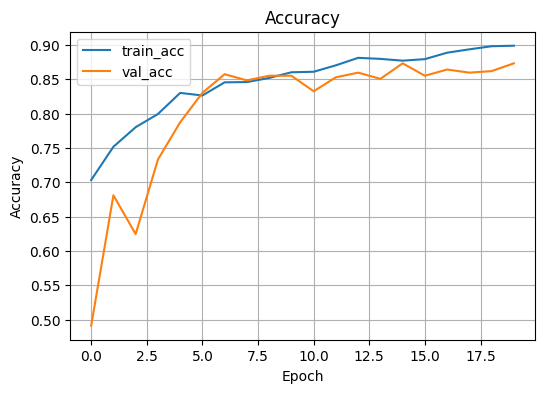

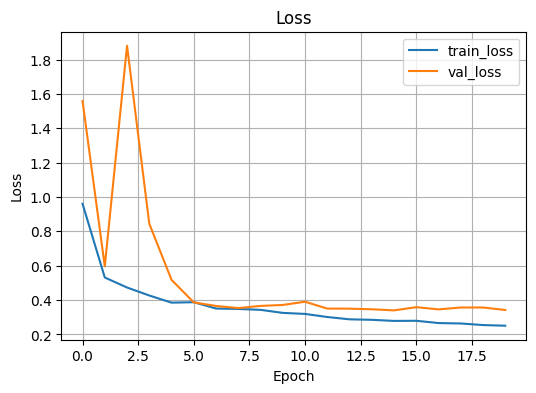

In [ ]:
def plot_training(history):
    hist = history.history

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training(history)


In [ ]:
best_model = tf.keras.models.load_model(checkpoint_path)
best_model.summary()


Model: "bird_vs_drone_custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,459 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Basic Keras evaluation
test_metrics = best_model.evaluate(test_gen, verbose=1)
print("\nTest Metrics (Keras):")
for name, value in zip(best_model.metrics_names, test_metrics):
    print(f"{name}: {value:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.9239 - loss: 0.2163 - precision: 0.4853 - recall: 0.5568

Test Metrics (Keras):
loss: 0.2532
compile_metrics: 0.9023


In [ ]:
# Predict probabilities
y_prob = best_model.predict(test_gen)
y_pred = (y_prob.ravel() > 0.5).astype(int)
y_true = test_gen.classes

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step
y_true shape: (215,)
y_pred shape: (215,)


In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm


array([[112,   9],
       [ 12,  82]])

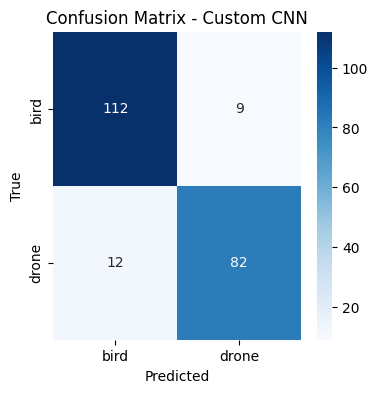

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN")
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))

f1 = f1_score(y_true, y_pred)
print(f"F1-score (binary, positive='drone' if label 1): {f1:.4f}")


Classification Report:

              precision    recall  f1-score   support

        bird       0.90      0.93      0.91       121
       drone       0.90      0.87      0.89        94

    accuracy                           0.90       215
   macro avg       0.90      0.90      0.90       215
weighted avg       0.90      0.90      0.90       215

F1-score (binary, positive='drone' if label 1): 0.8865
